# <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">U-Net: Massachusetts Building Segmentation</p>

<p style="text-align:justify; ">
    
Satellite images are one of the most powerful and important tools we have for monitoring the earth. They track the physical environment (water, air, land, vegetation) and the changing human footprint across the globe. Satellite imagery is used to measure, identify and track human activity. The technique of segmenting the satellite images helps us to develop the topographic details of the geographical area captured by the satellite.
    
Image segmentation is a commonly used technique in digital image processing and analysis to partition an image into multiple parts or regions, often based on the characteristics of the pixels in the image.  
    Satellite remote sensing has become one of the most efficient solutions for surveying the earth at local, regional, and global spatial scales.
</p> 


<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Importing Libraries</p>

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# !pip install torch-snippets==0.495
from torch_snippets import *


<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Dataset</p>

The dataset consists of $151$ aerial images of the Boston area. It covers mostly urban and suburban areas and buildings of all sizes. Each of the images has $1500 \times 1500$ pixels for an area of $2.25$ square kilometers. In total the dataset covers $340$ square kilometers area.

An accompanying **metadata.csv** is provided with each image ID, the split it belongs to, image urls and path to it.

In [3]:
IMG_ROOT = 'E:/mphti/training/building segment/data/'
df = pd.read_csv('E:/mphti/training/building segment/data/metadata.csv')

train_df = df.loc[df['split'] == 'train']
tst_df = df.loc[df['split'] == 'test']
print("Training dataset size:", len(train_df))
print("Test dataset size:", len(tst_df))

Training dataset size: 137
Test dataset size: 10


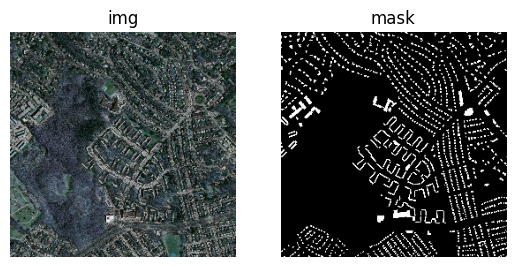

In [4]:
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

tfms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.3),
#     transforms.RandomRotation(40),
#     transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225])
])

class BuildingDatasetHighRes(Dataset):
    """
    Dataset for high-resolution building segmentation (512x512).
    """
    def __init__(self, df, root=IMG_ROOT, img_size=256):
        self.df = df
        self.root = root
        self.img_size = img_size
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.root + self.df.iloc[idx]['png_image_path']
        mask_path = self.root + self.df.iloc[idx]['png_label_path']
        
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        
        # Resize to 512x512
        img = cv2.resize(img, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        return img, mask
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy()/255.)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.tensor(mask)[None] for mask in masks]).float().to(device)
        return images, masks
    
tr_ds = BuildingDatasetHighRes(train_df)
tst_ds = BuildingDatasetHighRes(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tst_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[11]
fig, ax = plt.subplots(1, 2)
show(img, ax=ax[0])
show(mask, ax=ax[1])

<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Model</p>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# NEW COMPONENTS FOR HIGHER RESOLUTION AND QUALITY

class ResidualBlock(nn.Module):
    """
    Остаточный блок (Residual Block) для улучшенного градиентного потока.
    Позволяет сети обучаться более глубоким признакам без деградации.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut для matching размеров
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out


class AttentionGate(nn.Module):
    """
    Блок внимания (Attention Gate) для фокусировки на важных регионах.
    Помогает модели лучше определять границы зданий.
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        
        # Gating signal
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        
        # Skip connection
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        
        # Attention coefficients
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        # g: gating signal from decoder
        # x: skip connection from encoder
        
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        # Add and apply ReLU
        psi = self.relu(g1 + x1)
        
        # Apply sigmoid to get attention coefficients
        psi = self.psi(psi)
        
        # Weight the skip connection
        return x * psi


class ConvBlock(nn.Module):
    """
    Улучшенный сверточный блок с BatchNorm.
    """
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)


def up_conv(in_channels, out_channels):
    """Transposed convolution for upsampling."""
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )


# ENHANCED U-NET MODEL

class UNet(nn.Module):
    """
    Enhanced U-Net with Residual Blocks and Attention Gates.
    
    KEY IMPROVEMENTS:
    - Input size: 512x512 (vs 224x224 in original)
    - Residual Blocks for better gradient flow
    - Attention Gates for better boundary detection
    - Increased filters: 64 -> 128 -> 256 -> 512 -> 1024
    
    Args:
        in_channels: Number of input channels (3 for RGB)
        out_channels: Number of output channels (1 for binary segmentation)
        base_filters: Base number of filters (64)
    """
    def __init__(self, in_channels=3, out_channels=1, base_filters=64):
        super(UNet, self).__init__()
        
        # Encoder - с увеличенным количеством фильтров
        self.enc1 = ConvBlock(in_channels, base_filters)          # 64
        self.enc2 = ConvBlock(base_filters, base_filters * 2)      # 128
        self.enc3 = ConvBlock(base_filters * 2, base_filters * 4) # 256
        self.enc4 = ConvBlock(base_filters * 4, base_filters * 8) # 512
        
        # Bottleneck
        self.bottleneck = ResidualBlock(base_filters * 8, base_filters * 16)  # 1024
        
        # Decoder с Attention Gates
        self.up_conv4 = up_conv(base_filters * 16, base_filters * 8)
        self.att4 = AttentionGate(F_g=base_filters * 8, F_l=base_filters * 8, F_int=base_filters * 4)
        self.dec4 = ConvBlock(base_filters * 16, base_filters * 8)
        
        self.up_conv3 = up_conv(base_filters * 8, base_filters * 4)
        self.att3 = AttentionGate(F_g=base_filters * 4, F_l=base_filters * 4, F_int=base_filters * 2)
        self.dec3 = ConvBlock(base_filters * 8, base_filters * 4)
        
        self.up_conv2 = up_conv(base_filters * 4, base_filters * 2)
        self.att2 = AttentionGate(F_g=base_filters * 2, F_l=base_filters * 2, F_int=base_filters)
        self.dec2 = ConvBlock(base_filters * 4, base_filters * 2)
        
        self.up_conv1 = up_conv(base_filters * 2, base_filters)
        self.att1 = AttentionGate(F_g=base_filters, F_l=base_filters, F_int=base_filters // 2)
        self.dec1 = ConvBlock(base_filters * 2, base_filters)
        
        # Output layer
        self.final_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)
        
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder с Attention
        d4 = self.up_conv4(b)
        e4_att = self.att4(g=d4, x=e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))
        
        d3 = self.up_conv3(d4)
        e3_att = self.att3(g=d3, x=e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))
        
        d2 = self.up_conv2(d3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))
        
        d1 = self.up_conv1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))
        
        return self.final_conv(d1)

# MODEL INITIALIZATION

# Параметры для новой модели
IMG_SIZE = 256  # Увеличенный размер изображения

# Инициализация новой модели
model = UNet(in_channels=3, out_channels=1, base_filters=64).to(device)

# Тест модели
x = torch.randn(1, 3, 256, 256).to(device)
y = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Training</p>

In [7]:
# Очистите CUDA и перезапустите
import torch
torch.cuda.empty_cache()

# Или используйте более старый метод
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def loss_fn(preds, targets):
    # Преобразуем маску: все что > 0 становится 1, остальное 0
    # Это критически важно, если в маске значения 255
    targets = (targets > 0).long()
    
    criterion = nn.CrossEntropyLoss()
    loss = criterion(preds, targets)
    
    # Для точности: берем индекс максимального значения
    acc = (torch.argmax(preds, dim=1) == targets).float().mean()
    return loss, acc

def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = batch
    
    # Проверка размерностей для отладки
    # print("Preds shape will be:", imgs.shape) 
    # print("Masks shape:", masks.shape, "Unique values:", torch.unique(masks))
    
    # Если маски имеют размер (B, 1, H, W), убираем размерность канала
    if masks.dim() == 4 and masks.shape[1] == 1:
        masks = masks.squeeze(1)
        
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    pred_masks = model(imgs)
    loss, acc = loss_fn(pred_masks, masks)
    return loss.item(), acc.item()


In [12]:
model = UNet(out_channels=2).to(device)
optim = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = loss_fn
n_epochs = 100
log = Report(n_epochs)
for e in range(n_epochs):
    
    N = len(tr_dl)
    for i, batch in enumerate(tr_dl):
        
        loss, acc = train_batch(model, batch, optim, loss_fn)
        log.record(e+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(tst_dl)
    for i, batch in enumerate(tst_dl):
        
        loss, acc = validate_batch(model, batch, loss_fn)
        log.record(e+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')
  
    log.report_avgs(e+1)

0
EPOCH: 0.029  trn_loss: 0.754  trn_acc: 0.561  (0.61s - 2062.96s remaining)1
EPOCH: 0.059  trn_loss: 0.705  trn_acc: 0.515  (0.94s - 1598.58s remaining)2
EPOCH: 0.088  trn_loss: 0.677  trn_acc: 0.575  (1.32s - 1493.38s remaining)3
EPOCH: 0.118  trn_loss: 0.651  trn_acc: 0.613  (1.71s - 1449.08s remaining)4
EPOCH: 0.147  trn_loss: 0.605  trn_acc: 0.697  (2.07s - 1408.77s remaining)5
EPOCH: 0.176  trn_loss: 0.586  trn_acc: 0.693  (2.47s - 1397.61s remaining)6
EPOCH: 0.206  trn_loss: 0.578  trn_acc: 0.707  (2.84s - 1374.50s remaining)7
EPOCH: 0.235  trn_loss: 0.538  trn_acc: 0.757  (3.20s - 1357.50s remaining)8
EPOCH: 0.265  trn_loss: 0.502  trn_acc: 0.802  (3.57s - 1344.57s remaining)9
EPOCH: 0.294  trn_loss: 0.493  trn_acc: 0.809  (3.94s - 1335.51s remaining)10
EPOCH: 0.324  trn_loss: 0.505  trn_acc: 0.789  (4.32s - 1332.04s remaining)11
EPOCH: 0.353  trn_loss: 0.499  trn_acc: 0.738  (4.68s - 1322.58s remaining)12
EPOCH: 0.382  trn_loss: 0.528  trn_acc: 0.760  (5.04s - 1312.71s remain

In [21]:
import torch
import os
from pathlib import Path

def save_model(model, model_name, model_dir='nn_models'):
    """
    Сохраняет обученную модель и веса.
    
    Аргументы:
        model: Обученная модель PyTorch
        model_name: Имя для сохранения модели (без расширения)
        model_dir: Директория для сохранения (по умолчанию 'models')
    """
    # Создаем директорию если не существует
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    
    # Путь для сохранения весов
    weights_path = os.path.join(model_dir, f"{model_name}_weights.pth")
    
    # Путь для сохранения архитектуры модели
    model_path = os.path.join(model_dir, f"{model_name}_model.pth")
    
    # Сохраняем веса
    torch.save(model.state_dict(), weights_path)
    
    # Сохраняем архитектуру модели
    torch.save(model, model_path)
    
    print(f"Модель '{model_name}' успешно сохранена!")
    print(f"Веса: {weights_path}")
    print(f"Архитектура: {model_path}")



In [22]:
# Сохранение модели
save_model(model, "buildings_segmentation")

Модель 'buildings_segmentation' успешно сохранена!
Веса: nn_models\buildings_segmentation_weights.pth
Архитектура: nn_models\buildings_segmentation_model.pth


In [33]:
# building_segmentation.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import numpy as np
from pathlib import Path

# Устройство для вычислений
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Трансформации для предобработки изображений
preprocess_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_model(model_dir='nn_models', device=device):
    """
    Загружает сохраненную модель сегментации зданий.
    
    Аргументы:
        model_dir: Директория с сохраненными весами и моделью
        device: Устройство для вычислений
    
    Возвращает:
        Загруженную модель
    """
    # Пути к файлам
    weights_path = Path(model_dir) / 'buildings_segmentation_weights.pth'
    model_path = Path(model_dir) / 'buildings_segmentation_model.pth'
    
    # Проверяем существование файлов
    if not weights_path.exists() or not model_path.exists():
        raise FileNotFoundError(f"Модель не найдена в директории '{model_dir}'")
    
    # Загружаем архитектуру модели
    model = torch.load(model_path, map_location=device)
    
    # Загружаем веса
    model.load_state_dict(torch.load(weights_path, map_location=device))
    
    # Переводим модель в режим оценки
    model.eval()
    
    print(f"Модель успешно загружена на устройство '{device}'")
    
    return model

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Предобработка изображения для модели.
    
    Аргументы:
        image_path: Путь к изображению
        target_size: Целевой размер изображения
    
    Возвращает:
        preprocessed_image: Предобработанное изображение
        original_image: Оригинальное изображение
    """
    # Чтение изображения
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError(f"Не удалось прочитать изображение: {image_path}")
    
    # Конвертация из BGR в RGB
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Изменение размера
    resized_image = cv2.resize(original_image, target_size)
    
    # Применение трансформаций
    preprocessed_image = preprocess_transform(resized_image)
    
    return preprocessed_image, original_image

def segment_image(image_path, model, device=device):
    """
    Прогон изображения через модель сегментации.
    
    Аргументы:
        image_path: Путь к изображению
        model: Загруженная модель
        device: Устройство для вычислений
    
    Возвращает:
        mask: Массив с маской сегментации
        original_image: Оригинальное изображение
    """
    # Предобработка изображения
    preprocessed_image, original_image = preprocess_image(image_path)
    
    # Добавляем batch dimension
    input_tensor = preprocessed_image.unsqueeze(0).to(device)
    
    # Прогон через модель
    with torch.no_grad():
        output = model(input_tensor)
    
    # Получаем маску
    _, predicted = torch.max(output, dim=1)
    mask = predicted.squeeze(0).cpu().numpy()
    
    return mask, original_image

def visualize_segmentation(mask, original_image):
    """
    Визуализация результата сегментации.
    
    Аргументы:
        mask: Массив с маской сегментации
        original_image: Оригинальное изображение
    
    Возвращает:
        Результат визуализации
    """
    
    # Изменяем размер маски до оригинальных размеров изображения
    mask_resized = cv2.resize(mask.astype(np.uint8), (original_image.shape[1], original_image.shape[0]), 
                             interpolation=cv2.INTER_NEAREST)
    
    # Создаем цветную маску из измененной маски
    colored_mask = cv2.applyColorMap(mask_resized, cv2.COLORMAP_JET)
    
    # Наложение маски на оригинальное изображение
    alpha = 0.5
    blended = cv2.addWeighted(original_image, alpha, colored_mask, 1 - alpha, 0)
    
    return blended

# Загружаем модель
model = load_model()
    
# Путь к тестовому изображению
test_image_path = r'C:\Users\Kirilll\Desktop\train_105.png'
    
# Прогон изображения через модель
mask, original_image = segment_image(test_image_path, model)
    
# Визуализация результата
result = visualize_segmentation(mask, original_image)
    
# Сохранение результата
cv2.imwrite('segmentation_result0.jpg', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
print(f"Результат сегментации сохранен как 'segmentation_result.jpg'")


C:\Users\Kirilll\AppData\Local\Temp\ipykernel_5180\2330305219.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)
C:\Use

Модель успешно загружена на устройство 'cuda'
Результат сегментации сохранен как 'segmentation_result.jpg'


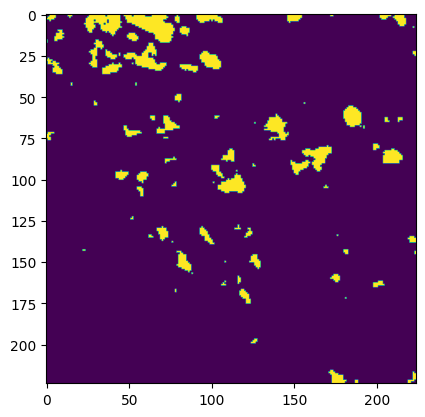

In [34]:
plt.imshow(mask)

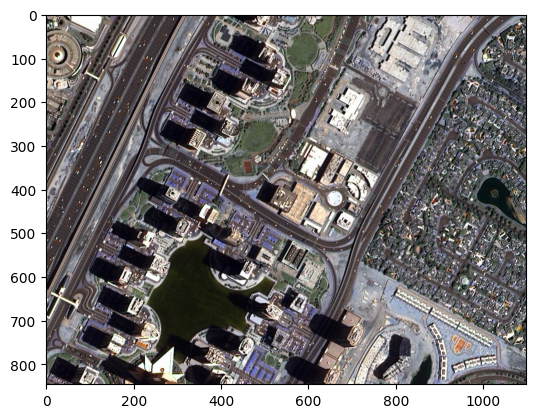

In [29]:
plt.imshow(original_image)

100%|██████████| 156/156 [00:00<00:00, 4875.10it/s]


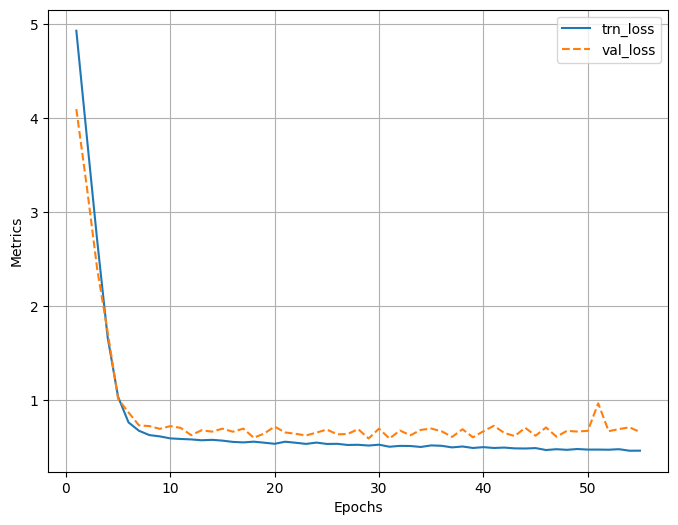

In [8]:
log.plot_epochs(['trn_loss', 'val_loss'])

<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Testing</p>

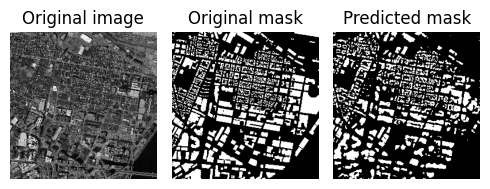

In [17]:
im, mask = next(iter(tst_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

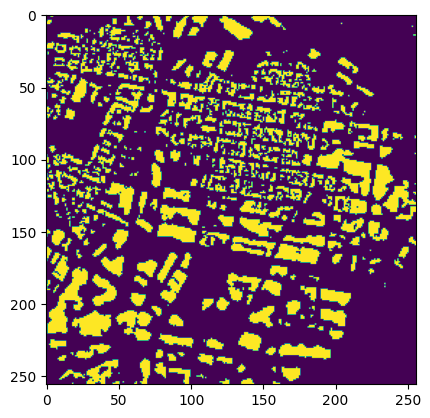

In [19]:
# plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])
plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0])

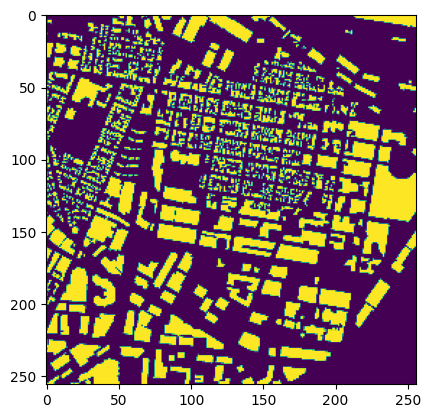

In [20]:
plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])

---